In [16]:
# Step 1: Clone the FlowTurbo repository
!git clone https://github.com/AasthaMariamJohn/FlowTurbo-Implementation.git

# Step 2: Moving to correct folder
%cd FlowTurbo-Implementation
%cd code

# Step 3: Setting up environment
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install tqdm numpy pillow scipy matplotlib
!pip install einops opencv-python scikit-learn
!pip install requests h5py
!wget https://cloud.tsinghua.edu.cn/f/3d07d92dd2314857ae50/?dl=1 -O SiT-XL-2-Refiner.pt
!git clone https://github.com/willisma/SiT.git

Cloning into 'FlowTurbo-Implementation'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 94 (delta 35), reused 20 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 9.98 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/FlowTurbo-Implementation/code/SiT/FlowTurbo-Implementation
/content/FlowTurbo-Implementation/code/SiT/FlowTurbo-Implementation/code
Looking in indexes: https://download.pytorch.org/whl/cu117
--2024-10-22 17:20:14--  https://cloud.tsinghua.edu.cn/f/3d07d92dd2314857ae50/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.15.69, 2402:f000:1:402:101:6:15:69
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.15.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/1a777c96-83b2-4dfc-807d-037c71cedcae/SiT-XL-2-Refiner.pt [following]


In [2]:
# Step 4: Downloading dataset if you are intending on using ALL 1000 CLASSES
import kagglehub
tianbaiyutoby_islvrc_2012_10_pecent_subset_path = kagglehub.dataset_download('tianbaiyutoby/islvrc-2012-10-pecent-subset')
print('Data source import complete.')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

100%|██████████| 13.6G/13.6G [03:23<00:00, 71.5MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
dataset_path = tianbaiyutoby_islvrc_2012_10_pecent_subset_path
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_2581.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_8110.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_5822.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_1863.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_476.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_5358.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_3191.JPEG
/root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/n01824575/n01824575_1269.JPEG
/root/.cache/kagglehub

In [3]:
# Step 4: Downloading dataset if like me you lack computing resources,
#it is a very small dataset of only two approx classes made by me from the larger subset only consisting of two classes, dog and cat
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/ILVSRC2012_Small_subset" # change path according to the path of the data folder in your drive

In [5]:
import os
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3221.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3210.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3209.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3217.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3222.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3220.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3216.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/322.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3208.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3211.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3213.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3212.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3218.jpg
/content/drive/MyDrive/ILVSRC2012_Small_subset/train/207/3214.jpg
/content/drive/MyDrive/ILV

In [17]:
import SiT, os
os.chdir('SiT')
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
!pip install diffusers timm torchdiffeq --upgrade
# SiT imports:
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.3
    Uninstalling diffusers-0.30.3:
      Successfully uninstalled diffusers-0.30.3


In [7]:
# Step 5: Loading the vae autoencoder model
image_size = "256"
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = SiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"SiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2700608707/2700608707 [02:34<00:00, 17446801.99it/s]
/content/FlowTurbo-Implementation/code/SiT/download.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

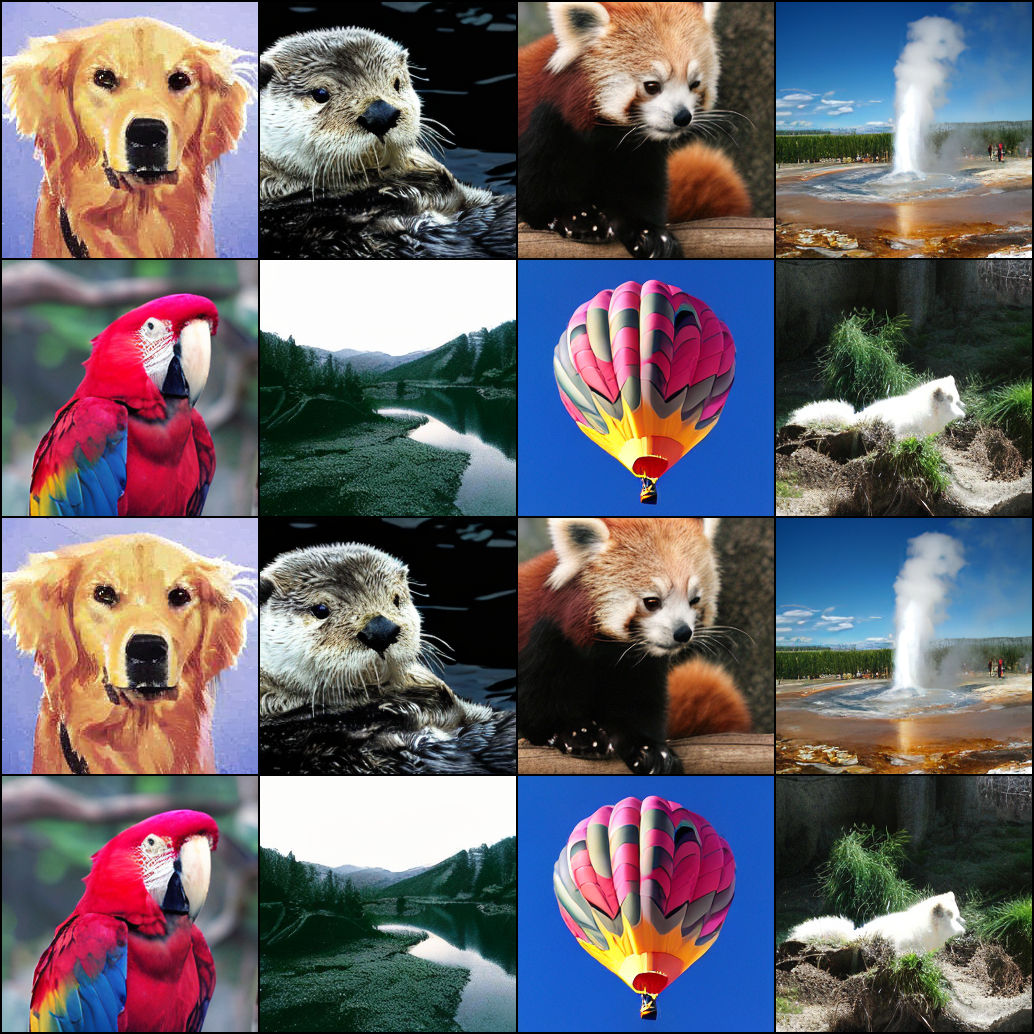

In [14]:
#VERY IMPORTANT TO RUN THIS, TAKES APPROX 2HRS
#REST OF THE CODE KEYBOARD INTERRUPTS IF THIS IS NOT
#RUN
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
sampler_type = "ODE" #@param ["ODE", "SDE"]


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler" #@param ["Euler", "Heun"]
    diffusion_form = "linear" #@param ["constant", "SBDM", "sigma", "linear", "decreasing", "increasing-decreasing"]
    diffusion_norm = 1 #@param {type:"slider", min:0, max:10.0, step:0.1}
    last_step = "Mean" #@param ["Mean", "Tweedie", "Euler"]
    last_step_size = 0.4 #@param {type:"slider", min:0, max:1.0, step:0.01}
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form,
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size,
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" #@param ["dopri5", "euler", "rk4"]
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )
samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [15]:
!pwd
%cd ..

/content/FlowTurbo-Implementation/code/SiT
/content/FlowTurbo-Implementation/code


In [2]:
%cd FlowTurbo-Implementation/code

/content/FlowTurbo-Implementation/code


In [1]:
!mv /content/FlowTurbo-Implementation/code/SiT/pretrained_models/SiT-XL-2-256x256.pt /content/FlowTurbo-Implementation/code/

In [2]:
%cd FlowTurbo-Implementation
%cd code

/content/FlowTurbo-Implementation
/content/FlowTurbo-Implementation/code


In [25]:
# Step 6: Environment deployment
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')
!conda env create -f environment.yml
!source activate FlowTurbo

Streaming output truncated to the last 5000 lines.
pytorch-2.5.0        | 1.46 GB   | :   3% 0.027945565081099126/1 [00:05<10:55, 674.06s/it]

torchtriton-3.1.0    | 233.6 MB  | :  18% 0.1771918030298345/1 [00:05<01:22, 99.86s/it] 



libcusparse-12.3.1.1 | 179.6 MB  | :  24% 0.23611996356865944/1 [00:05<00:56, 74.49s/it]


libcufft-11.2.1.3    | 190.5 MB  | :  23% 0.2260981867652096/1 [00:05<01:02, 80.29s/it] 
pytorch-2.5.0        | 1.46 GB   | :   3% 0.02818548594592379/1 [00:06<11:13, 693.51s/it] 

torchtriton-3.1.0    | 233.6 MB  | :  18% 0.17919850521590286/1 [00:06<01:25, 103.86s/it]



pytorch-2.5.0        | 1.46 GB   | :   3% 0.02839411278490176/1 [00:06<11:42, 722.65s/it]


libcufft-11.2.1.3    | 190.5 MB  | :  23% 0.2286404587237593/1 [00:06<01:04, 84.20s/it]
libcublas-12.4.5.8   | 309.2 MB  | :  14% 0.13771271385875547/1 [00:06<02:04, 144.53s/it]

torchtriton-3.1.0    | 233.6 MB  | :  18% 0.18080386696475753/1 [00:06<01:28, 107.47s/it]



pytorch-2.5.0        | 1.46 GB   | :

In [8]:
# Step 7: Training
#MIN 1 GPU REQUIRED FOR TRAINING OTHERWISE IT WONT RUN, IF NO GPU THEN SKIP TO SAMPLING
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [26]:
# Minimal training with small dataset and min possible evaluation parameters
!torchrun --nnodes=1 --nproc_per_node=1 train.py --model SiT-XL/2 --data-path /content/drive/MyDrive/ILVSRC2012_Small_subset/train

2024-10-22 12:48:32.400277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 12:48:32.434457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 12:48:32.444099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 12:48:34.303751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Training for 50 epochs...
[Epoch 01/50] Time per epoch: 583s Loss: 77.01 Log-likelihood: -4.34 
[Epoch 02/50] Time per epoch: 583s Loss: 74.78 Log-likelihood: -4.31 
[Epoch 03/50] Time per epoch: 583s Loss: 73.53 Log-likelihood: -4.30 
[Epoc

In [1]:
# Training with the full 1000 class dataset, not possible with the google collab GPU will need better acess
!CUDA_VISIBLE_DEVICES=0 torchrun --nnodes=1 --nproc_per_node=1 --master_port 12345 train.py \
    --data-path /root/.cache/kagglehub/datasets/tianbaiyutoby/islvrc-2012-10-pecent-subset/versions/1/ \
    --global-batch-size 18 \
    --note 'TRIAL 1' \
    --ckpt-every 5000 \
    --lr 5e-5 \
    --vae_ckpt stabilityai/sd-vae-ft-ema \
    --model_teacher_ckpt SiT-XL-2-256x256.pt

/usr/bin/python3: can't open file '/content/train.py': [Errno 2] No such file or directory
E1022 16:59:27.341000 133437221425152 torch/distributed/elastic/multiprocessing/api.py:833] failed (exitcode: 2) local_rank: 0 (pid: 530) of binary: /usr/bin/python3
Traceback (most recent call last):
  File "/usr/local/bin/torchrun", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 348, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/run.py", line 901, in main
    run(args)
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/run.py", line 892, in run
    elastic_launch(
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/launcher/api.py", line 133, in __call__
    return launch_agent(self._config, self._entrypoint, list(args))
  File "/usr/local/lib/python3.10/dist-packages/torch/distributed/launcher/api

In [5]:
# Step 8: Testing the results
!python sample.py --predictor_ckpt SiT-XL-2-256x256.pt --refiner_ckpt SiT-XL-2-Refiner.pt \
    --num_samples 100 --output_dir ./samples --image_resolution 256x256

2024-10-22 14:43:08.701205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 14:43:08.764052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 14:43:08.782291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 14:43:08.832914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 14:43:11.540879: W tensorflow/compiler/tf2

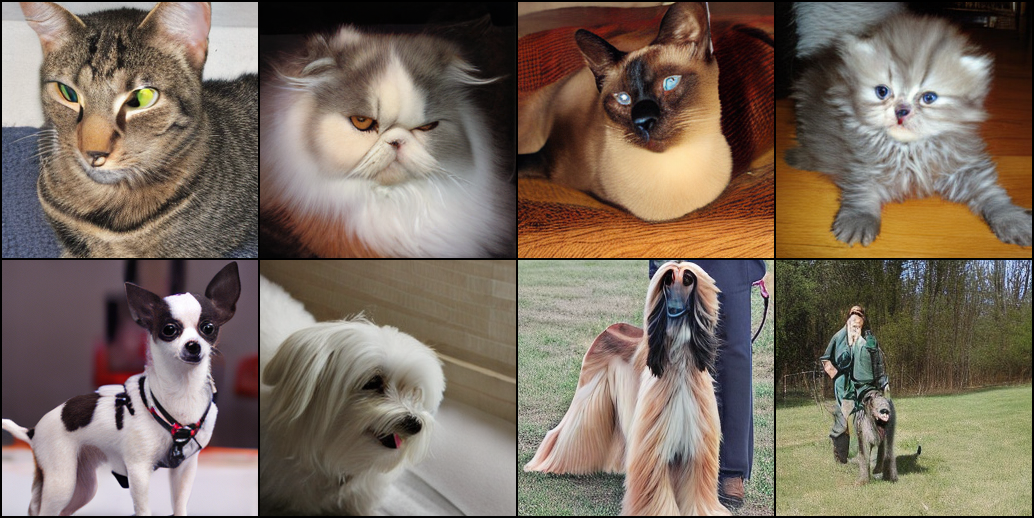

In [7]:
from IPython.display import Image, display
image_path = "sample_N_H1N_P5N_R3SACFalse.png"
display(Image(image_path))

In [5]:
!pwd
%cd FlowTurbo-Implementation/code

/content/FlowTurbo-Implementation/code


In [32]:
mkdir -p ./samples

In [33]:
ls

download.py*         requirements.txt*                sample.py*           train_utils.py*
environment.yml*     sample_ddp_feature.py*           samples/             transport/
evaluation/          sample_in_dir.py                 SiT/
LICENSE*             sample_N_H1N_P5N_R3SACFalse.png  SiT-XL-2-Refiner.pt
models_assemble.py*  sample.png                       train.py*


In [6]:
# Step 9: Sampling to get output for the evaluation scripts to run
#NEEDS ATLEAST 1 GPU WILL NOT RUN ON CPU
!python sample_ddp_feature.py \
    --vae_ckpt stabilityai/sd-vae-ft-ema \
    --predictor_ckpt SiT-XL-2-256x256.pt \
    --refiner_ckpt SiT-XL-2-Refiner.pt \
    --num_fid_samples 60 --per_proc_batch_size 10 --cfg_scale 1.5 \
    --tag TEST

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2024-10-22 17:13:15.322690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 17:13:15.342545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 17:13:15.348352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 17:13:15.362560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimiz

In [4]:
# Made a new script that works on CPU but gives only 8 samples
!python sample_in_dir.py \
    --predictor_ckpt SiT-XL-2-256x256.pt \
    --refiner_ckpt SiT-XL-2-Refiner.pt \
    --num_samples 100 \
    --output_dir ./samples \
    --image_resolution 256x256

2024-10-22 14:14:19.792359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 14:14:19.969976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 14:14:20.021367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 14:14:20.303515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 14:14:22.495837: W tensorflow/compiler/tf2

In [9]:
# Step 10: Evaluation (Full)
#Please download the reference file to do the evaluation
# the reference npz can be downloaded via
# https://openaipublic.blob.core.windows.net/diffusion/jul-2021/ref_batches/imagenet/256/VIRTUAL_imagenet256_labeled.npz
# File is 2GB
!python evaluation/evaluator.py ./VIRTUAL_imagenet256_labeled.npz ./sample.zip

2024-10-22 15:41:47.333117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 15:41:47.379056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 15:41:47.392745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 15:41:47.445497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 15:41:49.512044: W tensorflow/compiler/tf2

In [11]:
import torchvision.models as models

# Load the pre-trained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 84.7MB/s] 


In [16]:
!python fid.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
FID score: 3.54
